## Access Satellite GHRSST L3S 1Day Day and Night time Single Sensor Southernocean data in Zarr
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l3s_1day_daynighttime_single_sensor_southernocean"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 230 packages in 24ms


In [4]:
import requests
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [5]:
from parquet_queries import plot_gridded_variable, create_timeseries, plot_time_coverage

In [6]:
# remote zarr dataset
import dask

url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 384GB
Dimensions:                          (time: 120, lat: 2500, lon: 10000)
Coordinates:
  * lat                              (lat) float32 10kB -27.51 -27.53 ... -77.49
  * lon                              (lon) float32 40kB 2.51 2.53 ... 202.5
  * time                             (time) datetime64[ns] 960B 1992-03-21T11...
Data variables: (12/16)
    dt_analysis                      (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    l2p_flags                        (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    quality_level                    (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    satellite_zenith_angle           (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    sea_ice_fraction                 (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    sea_ice_fraction_dtime_from_sst  (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    ...                               ...
    sst_count                        (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    sst_dtime                        (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    sst_mean                         (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    sst_standard_deviation           (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    wind_speed                       (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
    wind_speed_dtime_from_sst        (time, lat, lon) float64 24GB dask.array<chunksize=(5, 250, 250), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          A merged, day+night, multi-sensor L3S f...
    time_coverage_end:                19920710T222338Z
    time_coverage_start:              19920710T035632Z
    title:                            IMOS L3S Day and Night gridded multiple...
    uuid:                             792b61f8-42bf-45a4-a79e-41f479e825a9
    westernmost_longitude:            2.509999990463257

In [7]:
import dask

# This function only gets run when dask needs to look at the result
@dask.delayed
def open_zarr_dataset(dataset_name):
    url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
    return xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)

ds = open_zarr_dataset(dataset_name)
ds.info()

Delayed('info-a87f0448-b466-4589-82a2-cdd3dcde0a59')

In [8]:
import dask
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
def plot_time_coverage(ds, time_var="time"):
    """
    Plots the time coverage of the given xarray dataset.

    Args:
        ds (xarray.Dataset): The input dataset containing a 'time' dimension.
    """
    # Convert the time dimension to a pandas DatetimeIndex
    ds = ds.sortby("time")

    time_series = pd.to_datetime(ds[time_var].compute().values)
    # Create a DataFrame with the year and month as separate columns
    time_df = pd.DataFrame({"year": time_series.year, "month": time_series.month})

    # Create a pivot table counting the occurrences of data points per year-month combination
    coverage = time_df.groupby(["year", "month"]).size().unstack(fill_value=0)

    # Only include the available months and years in the dataset
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(
        coverage.T, cmap="Greens", cbar=True, linewidths=0.5, square=True, vmin=0
    )

    # Customize plot
    plt.title("Time Coverage (per month)")
    plt.xlabel("Year")
    plt.ylabel("Month")

    # Set the color bar title
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_label("N Data Points per Month")

    # Adjust y-axis ticks to only show months that are present in the dataset
    available_months = coverage.columns.get_level_values(0).unique()
    plt.yticks(
        ticks=range(len(available_months)),
        labels=[f"{i:02d}" for i in available_months],
        rotation=45,
    )
    plt.xticks(rotation=45)

## Plot time coverage

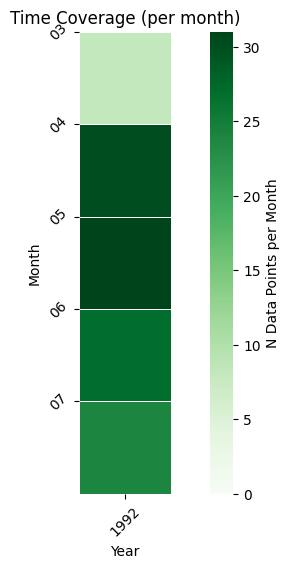

In [9]:
plot_time_coverage(ds)

## Timeseries at a point

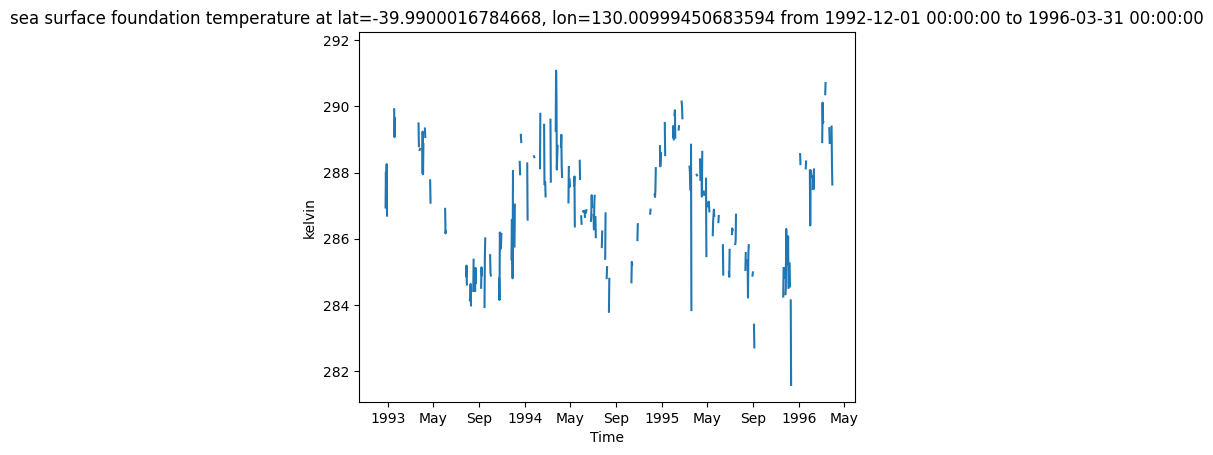

CPU times: user 7.85 s, sys: 1.35 s, total: 9.2 s
Wall time: 29.3 s


In [8]:
%%time
time_series_df = create_timeseries(ds, 'sea_surface_temperature', lat=-40, lon=130, start_time='1992-12-01', end_time='1996-03-31')

## Plot a gridded variable

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('1995-01-26T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1995-01-26T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea surface foundation temperature


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:633: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


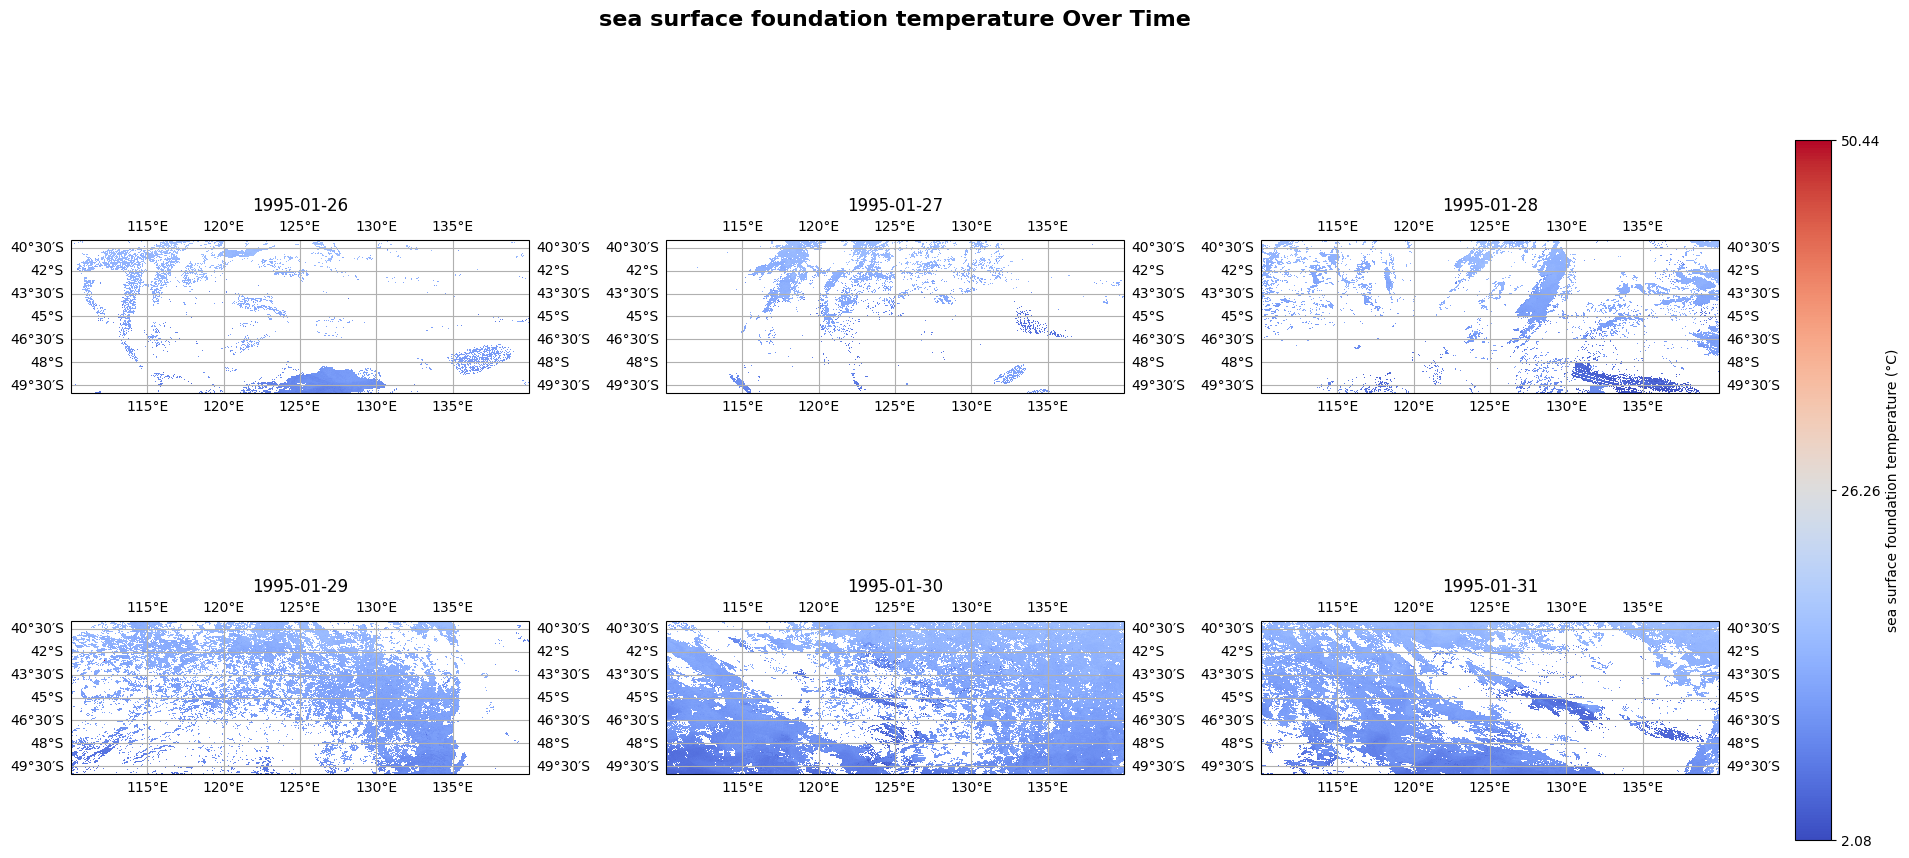

In [9]:
plot_gridded_variable(ds, start_date='1995-01-26', lon_slice=(110, 140), lat_slice=(-50, -40), var_name='sea_surface_temperature', n_days=6, coastline_resolution="110m")

Nearest date in dataset: <xarray.DataArray 'time' ()> Size: 8B
array('1995-01-26T11:10:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1995-01-26T11:10:00
Attributes:
    axis:           T
    comment:        A typical reference time for data
    long_name:      reference time of sst file
    standard_name:  time
Variable Long Name: sea ice fraction


/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/parquet_queries.py:633: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


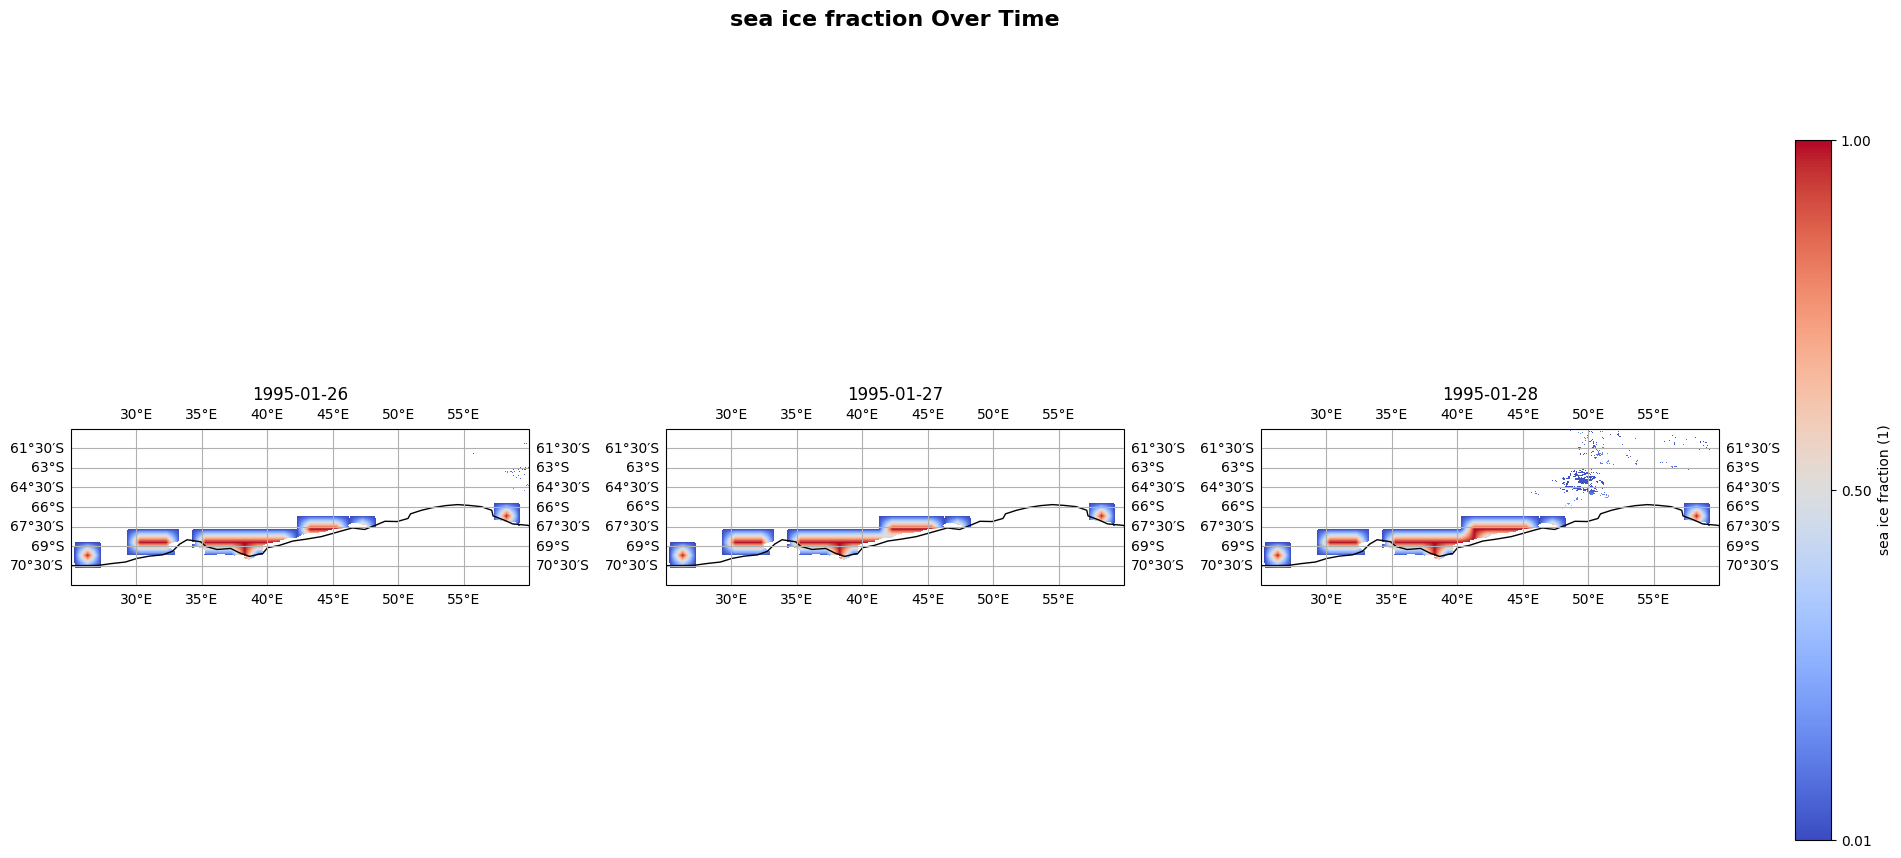

In [10]:
plot_gridded_variable(ds, start_date='1995-01-26', lon_slice=(25, 60), lat_slice=(-72, -60), var_name='sea_ice_fraction', n_days=3, coastline_resolution="110m")